# Import Libraries

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from datetime import date
from datetime import datetime

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import functional as F
from torch import nn, optim

from rdkit import Chem
from rdkit.Chem import Draw
import selfies as sf

In [2]:
# import chemVAE functions
from chemVAE import main

# One-Hot Encode SMILES Data
Dataset is from the Clean Energy Project https://www.worldcommunitygrid.org/research/cep1/overview.do

In [3]:
# load dataset
df = pd.read_csv('opv_molecules.csv')

# select SMILEs data
smiles = df['SMILES'].values

In [4]:
selfies = main.smiles2selfies(smiles) 

In [5]:
onehot_selfies, idx_to_symbol = main.onehotSELFIES(selfies)

# Load One-Hot Encoded Data into Pytorch Dataset

In [6]:
# split data in training and testing
X_train, X_test, y_train, y_test = train_test_split(onehot_selfies, onehot_selfies, test_size = 0.40)
X_test, X_val, y_test, y_val = train_test_split(X_test, X_test, test_size = 0.50)

In [7]:
# Pytroch Dataset
train_data = main.SELFIES_Dataset(X_train, y_train, transform = transforms.ToTensor())
test_data = main.SELFIES_Dataset(X_test, y_test, transform = transforms.ToTensor())
val_data = main.SELFIES_Dataset(X_val, y_val, transform = transforms.ToTensor())

# Set Model Parameters

In [8]:
num_characters, max_seq_len = onehot_selfies[0].shape
params = {'num_characters' : num_characters,
            'seq_length' : max_seq_len,
            'num_conv_layers' : 3,
            'layer1_filters' : 24,
            'layer2_filters' : 24,
            'layer3_filters' : 24,
            'layer4_filters' : 24,
            'kernel1_size' : 11,
            'kernel2_size' : 11,
            'kernel3_size' : 11,
            'kernel4_size' : 11,
            'lstm_stack_size' : 3,
            'lstm_num_neurons' : 396,
            'latent_dimensions' : 256,
            'batch_size' : 256,
            'epochs' : 500,
            'learning_rate' : 10**-4}

# Train Model

In [10]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training Model on: " + str(device))

# load data
train_loader = DataLoader(train_data, batch_size = params['batch_size'], shuffle = True)
test_loader = DataLoader(test_data, batch_size = params['batch_size'], shuffle = True)

# initialize model
model = main.VAE(params).to(device)

# set optimizer
optimizer = optim.Adam(model.parameters(), lr = params['learning_rate'])

# set KL annealing
KLD_alpha = np.linspace(0,1, params['epochs'])

## generate unique filenames
date = date.today()
now = datetime.now()
time = now.strftime("%H%M%S")
model_filename = "model_" + str(date)

Training Model on: cuda


NameError: name 'train_data' is not defined

In [13]:
# train model
epoch = params['epochs']
train_loss = []
test_loss = []
BCE_loss = []
KLD_loss = []
KLD_weight = []
for epoch in range(1,  epoch + 1):
        alpha = KLD_alpha[epoch-1]
        loss, BCE, KLD_wt, KLD = main.train(model, train_loader, optimizer, device, epoch, alpha)
        train_loss.append(loss)
        BCE_loss.append(BCE)
        KLD_loss.append(KLD)
        KLD_weight.append(KLD_wt)
        
        test_loss.append(main.test(model, test_loader, optimizer, device, epoch, alpha))    
        
# save model
## save model paramters
output = open(model_filename +'_parameters.pkl', 'wb')
pickle.dump(params, output)
output.close()
print("Saved PyTorch Parameters State to " + model_filename +'_parameters.pkl')

## save model state
torch.save(model.state_dict(), model_filename + '_state.pth')
print("Saved PyTorch Model State to " + model_filename + '_state.pth')

## save model state
torch.save(model, model_filename + '.pth')
print("Saved PyTorch Model State to " + model_filename + '_state.pth')

====> Epoch: 1 Average loss: 0.00881
====> Test set loss: 0.00727
====> Epoch: 2 Average loss: 0.00692
====> Test set loss: 0.00661
Saved PyTorch Model State to model_2021-08-04


# Deploy Model

In [14]:
# Load the model trained in the cell above

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## load parameters
pkl_file = open(model_filename + '_parameters.pkl', 'rb')
params = pickle.load(pkl_file)
pkl_file.close()

## load model state
model = main.VAE(params).to(device)
model.load_state_dict(torch.load(model_filename + '_state.pth'))

<All keys matched successfully>

In [9]:
# Load a pretrained model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## load parameters
pkl_file = open('pretrained_model_parameters.pkl', 'rb')
params = pickle.load(pkl_file)
pkl_file.close()

## load model state
model = main.VAE(params).to(device)
model.load_state_dict(torch.load('pretrained_model_state.pth'))

<All keys matched successfully>

In [10]:
# grab random sample from test_data
sample_idx = np.random.randint(0,len(test_data)-1)
img, label = train_data[sample_idx]

# run model
with torch.no_grad():
        img = img.to(device)
        recon_data, z, mu, logvar = model(img)
recon_data = recon_data[0].cpu()

# grab original smiles
sample = img[0].cpu().numpy()
char_ind = list(np.argmax(sample.squeeze(),axis=0))
string = [idx_to_symbol[i] for i in char_ind]
selfie = ''.join(string)
smiles = sf.decoder(selfie)

# reconstructed smiles
recon_sample = recon_data.numpy()
char_ind = list(np.argmax(recon_sample.squeeze(),axis=0))
string = [idx_to_symbol[i] for i in char_ind]
recon_selfie = ''.join(string)
recon_smiles = sf.decoder(recon_selfie)

Text(0.5, 1.0, 'Reconstruction')

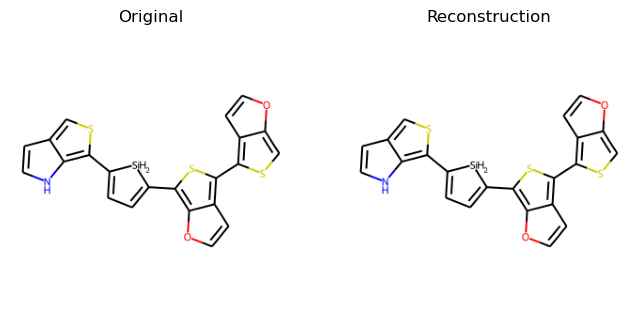

In [11]:
# visualize model reconstruction

## draw molecule and reconstruction
m1 = Chem.MolFromSmiles(smiles)
Draw.MolToFile(m1,'original.png') 

m2 = Chem.MolFromSmiles(recon_smiles)
Draw.MolToFile(m2,'reconstruct.png') 

## visualize molecules in notebokk
figure(figsize=(8, 6), dpi = 100)
plt.subplot(1,2,1)
img = mpimg.imread('original.png')
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1,2,2)
img = mpimg.imread('reconstruct.png')
plt.imshow(img)
plt.axis('off')
plt.title('Reconstruction')